In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap

In [5]:
df = pd.read_csv("./genetic_algorithm/train.csv")

In [7]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
target = 'Survived'
predictors = list(set(df._get_numeric_data().columns) - set([target]))

In [11]:
df[predictors] = df[predictors].fillna(0)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[target], test_size = 0.2, random_state=42)

In [27]:
rf = RandomForestClassifier(class_weight='balanced', n_estimators=50, max_depth=5, random_state=42, n_jobs=-1)

In [28]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [ ]:
X_train['random_variable'] =

In [48]:
 np.random.randint(20,size=X_train.shape[0])

array([12, 18,  2,  5,  4, 19, 15, 19, 18, 10,  2, 13,  0, 14,  3, 11, 19,
       18,  4, 17,  8,  5, 15, 16,  5, 10, 14,  6, 19,  4, 19,  9, 14,  3,
        6,  0, 19,  1, 14, 14, 14, 19, 11, 10,  1, 19,  5, 19, 19, 14,  3,
        6, 18,  6,  2,  6,  2,  2,  6,  1,  2,  5, 11,  9, 11, 10, 15, 16,
       13,  4,  6,  1, 18, 19, 12, 10, 19, 16,  7, 16,  3,  4,  0,  1,  7,
        3, 15,  5,  3,  7, 14,  8, 14, 12,  7,  3,  2, 10,  2, 15, 16, 16,
       13, 18,  2, 19,  3,  2, 16, 11,  3,  5, 17,  2, 15,  1, 19, 13, 13,
        1,  8, 15,  1,  2, 13,  7,  6,  6,  9,  4,  4,  6,  6, 12,  2,  9,
        3, 19, 16, 18,  5, 13, 11, 14,  5,  2, 18, 18,  3,  6, 14,  8, 19,
       19,  4,  9, 11, 16,  2,  3, 11,  0,  7, 10, 12, 10, 18,  5,  8,  3,
       14, 13,  7,  5, 19, 11,  7, 15, 11, 14,  3,  7, 18, 13,  9, 16, 17,
       14,  0,  8, 18,  8, 12,  3, 13,  6,  0,  9,  1,  6,  0, 13, 13, 17,
       13, 19, 13, 10, 19, 12,  3, 17, 11, 18, 18, 13,  8,  3, 16,  3,  1,
       10, 17, 13, 12,  4

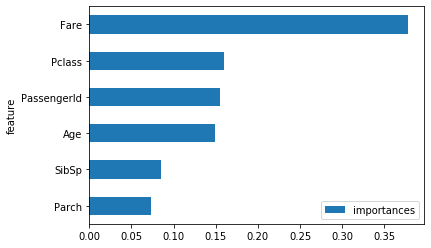

In [46]:
pd.DataFrame(np.dstack((X_train.columns, rf.feature_importances_))[0], columns=['feature','importances']).set_index('feature').sort_values(by='importances').plot.barh()

In [38]:
pd.DataFrame(np.dstack((X_train.columns, rf.feature_importances_)))

ValueError: Must pass 2-d input

In [4]:
class RandomFeatureSelector:
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        pass
    
    def transform(self, X, y=None):
        pass